In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, timedelta, datetime

data = pd.read_csv('complete.txt', sep=",", header=None)
data.columns = ["Name", "Date", "Time"]

# Time is irrelevant
del data["Time"]

### Main DataFrame ###

data = data.drop_duplicates().sort_values("Name")
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values("Date").drop_duplicates()

#### List of unique names of employees

In [2]:
### MIN MAX per employee ###

names = data["Name"]
names.value_counts()
list_names = names.unique()
#
list_names = list(list_names)
list_names[:5]

['Jaye Shimek', 'Leandro Marse', 'Kyle Ryals', 'Lorrine Paek', 'Zofia Roll']

#### Make DataFrame that contains info about when (which years) author was working

In [3]:
start_date = []
end_date = []

### Creates DF in which employees are active
## EG first and last date employee publishes

for name in list_names:
    subset = data[data["Name"] == name].sort_values("Date")
    start_date.append(min(subset["Date"]))
    end_date.append(max(subset["Date"]))

# Create DF from this
active = pd.DataFrame({'Name': list_names, 'Start': start_date, 'End': end_date})
active = active.sort_values("Start")
active = active.sort_values("End")
active = active.reset_index()
del active["index"]

#### Exclude weekends from possible working days, create range

In [4]:
# Take a subset of timeframe IF needed

start_date = '2012-01-01'
end_date = '2019-12-31'

subset = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

## Create list with all dates people normally work at
## So weekends are excluded.
## Not public holidays though

def possible_range(date1, date2):

    # prepare the input data-range
    begin = date1.astype(str).values[0].split('-')
    end = date2.astype(str).values[0].split('-')
    sdate = date(int(begin[0]), int(begin[1]), int(begin[2]))
    fdate = date(int(end[0]), int(end[1]), int(end[2]))

    def daterange(sdate, fdate):
        for n in range(int((fdate - sdate).days)+1):
            yield sdate + timedelta(n)

    all_dates = []
    weekdays = [6,7]

    for dt in daterange(sdate, fdate):
        if dt.isoweekday() not in weekdays:
            da = datetime.strftime(dt, "%Y-%m-%d")
            all_dates.append(da)

    df = pd.DataFrame(all_dates)
    df = pd.to_datetime(df[0])
    return set(df)


### Unique names that posted in the defined period

names_all = subset["Name"].unique()

### list of workingdays on which employees are absent (as a dict)

Also list with co-absences are created. That is, working days on which two coworkers are both absent

In [5]:
### Make dicts with employee as key,
### List of absences as value
### Used for plotting later

to_plot = dict()
absent_dict = dict()
pairs = []
values = []
namesAll = list(names_all)

for i in range(len(namesAll)):
    name = namesAll[i]
    row = active[active["Name"] == name]
    all = possible_range(row['Start'], row['End'])
    subsubset = subset[subset["Name"] == name]
    dates = set(subsubset["Date"])

    # Calculate difference between sets
    # Absent days are: all possible work days minus (-) the days an employee publishes
    absent =  all - dates

    # Append self, add own pair to dict
    pairs.append((name, name))
    values.append(len(absent))
    absent_dict[name] = absent

    for j in range(i+1, len(namesAll)):
        co_worker = namesAll[j]
        row_c = active[active["Name"] == co_worker]
        all_c = possible_range(row_c['Start'], row_c['End'])
        subsubset2 = subset[subset["Name"] == co_worker]
        co_dates = set(subsubset2["Date"])
        co_absent = all_c - co_dates

        # Days they are absent together
        # same absent days = absent days employee 1 has similar with absent days employee 2
        together = absent & co_absent
        pairs.append((name, co_worker))
        values.append(len(together))

co_absence = pd.DataFrame({'Pair': pairs, 'Co-absence': values})
co_absence = co_absence.sort_values("Co-absence", ascending=False)

#### Absences further examined and stored into csv

In [6]:
## OWN ABSENCES ##

own = []
val_own = []
# len_val = []
for self in co_absence.values:
    if self[0][0] == self[0][1]:
        own.append(self[0][0])
        val_own.append(self[1])
        # len_val.append(len(self[1]))

abs_self = pd.DataFrame({'Name': own, 'Absence': val_own})
abs_self = abs_self.sort_values("Absence", ascending=False)

merged_active = pd.merge(abs_self, active, on="Name", how="left")

years = []
avg_ = []
for row in merged_active.values:
    begin = str(row[2]).split('-')
    end = str(row[3]).split('-')
    years_ = int(end[0]) - int(begin[0]) + 1
    # 7 public holidays / year in the Netherlands

    avg = (int(row[1]) - (7*years_)) / years_
    avg_.append(avg)

merged_active["Avg abs/y"] = avg_
final = merged_active.sort_values("Avg abs/y", ascending=True)

### Average absences saved to csv file

final.to_csv("final_2.csv", index=False)

In [7]:
# Exclude parttimers

abs_ = pd.read_csv('final_2.csv')
normal_employees = abs_.head(30)

In [8]:
n = normal_employees.tail(10)

In [9]:
print(n.to_latex(index=False))

\begin{tabular}{lrllr}
\toprule
              Name &  Absence &       Start &         End &  Avg abs/y \\
\midrule
    Layne Woodside &      172 &  2012-01-02 &  2019-12-31 &     14.500 \\
      Narcisa Core &      173 &  2012-01-02 &  2019-12-31 &     14.625 \\
 Milagros Salmeron &      174 &  2012-01-02 &  2019-12-31 &     14.750 \\
     Leatrice Heer &      174 &  2012-01-02 &  2019-12-31 &     14.750 \\
      Michale Tuch &      175 &  2012-01-02 &  2019-12-31 &     14.875 \\
     Lester Preiss &      176 &  2012-01-02 &  2019-12-31 &     15.000 \\
        Vance Ates &       66 &  2012-01-02 &  2014-12-31 &     15.000 \\
   Stephine Gatlin &      177 &  2012-01-02 &  2019-12-31 &     15.125 \\
     Julieta Knapp &      179 &  2012-01-02 &  2019-12-31 &     15.375 \\
  Harmony Mcmurtry &      180 &  2012-01-02 &  2019-12-31 &     15.500 \\
\bottomrule
\end{tabular}



In [10]:
normal_employees.describe()

# Mean is 14 days. 15 However seems more plausible (3 weeks). And some years 6 instead of 7 national holidays days are common.

,Absence,Avg abs/y
count,30.000000,30.000000
mean,146.833333,14.082500
std,41.868500,0.889338
min,55.000000,11.333333
25%,131.500000,13.616667
50%,168.500000,14.125000
75%,172.750000,14.718750
max,180.000000,15.500000


## PLOTS

#### Absence patterns all employees

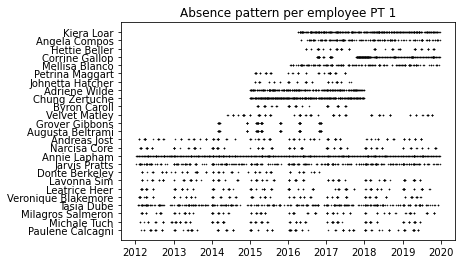

In [11]:
# Split dict in 2 to get more readable results

d1 = dict(list(absent_dict.items())[len(absent_dict)//2:])
d2 = dict(list(absent_dict.items())[:len(absent_dict)//2])

xs, ys = zip(*((x, k) for k in d1 for x in d1[k]))
plt.title("Absence pattern per employee PT 1")
plt.plot(xs, ys, 'ko', markersize=0.5)
plt.savefig("plots/absence-1B.png", bbox_inches='tight')
plt.show()

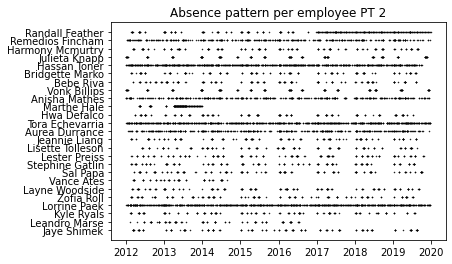

In [12]:
xz, yz = zip(*((x, k) for k in d2 for x in d2[k]))
plt.title("Absence pattern per employee PT 2")
plt.plot(xz, yz, 'ko', markersize=0.5)
plt.savefig("plots/absence-2B.png", bbox_inches='tight')
plt.show()

#### Identify couples

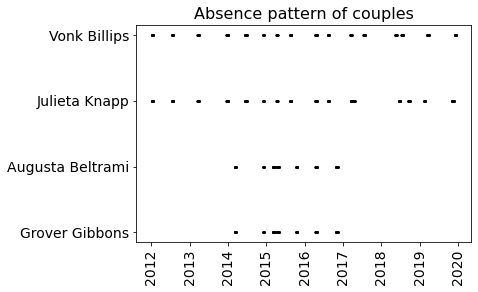

In [13]:
### Take individual employees and PLOT ###
### ABSENCE PATTERN OF COUPELS ###

pers_dict = dict()
name_n = "Grover Gibbons"
name_o = "Augusta Beltrami"
name_x = "Julieta Knapp"
name_y = "Vonk Billips"
name_list = [name_n, name_o, name_x, name_y]
tussen = absent_dict[name_o]
tussen2 = absent_dict[name_n]
tussen3 = absent_dict[name_x]
tussen4 = absent_dict[name_y]

pers_dict[name_n] = tussen2
pers_dict[name_o] = tussen
pers_dict[name_x] = tussen3
pers_dict[name_y] = tussen4

xs, ys = zip(*((x, k) for k in pers_dict for x in pers_dict[k]))
plt.title("Absence pattern of couples", size = 16)
plt.plot(xs, ys, 'ko', markersize=1.5)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.savefig("plots/grover-augusta-billips-knapp.png", bbox_inches='tight')
plt.show()

#### Suspected parttimers

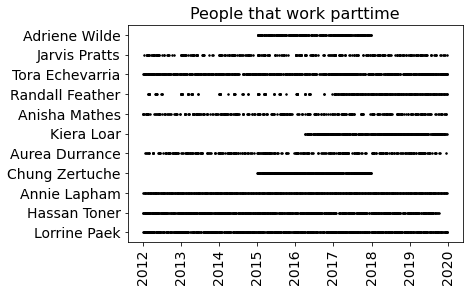

In [14]:
### Take individual employees and PLOT ###
### ABSENCE PATTERN OF COUPELS ###
## list of parttimers

list_pt = ["Lorrine Paek", "Hassan Toner", "Annie Lapham", "Chung Zertuche", "Aurea Durrance", "Kiera Loar", "Randall Feather",
          "Tora Echevarria", "Jarvis Pratts", "Anisha Mathes", "Adriene Wilde"]

pers_dict = dict()
name_n = "Lorrine Paek"
name_o = "Hassan Toner"
name_x = "Annie Lapham"
name_y = "Chung Zertuche"
name_z = "Aurea Durrance"
name_a = "Kiera Loar"
name_b = "Anisha Mathes"
name_c = "Randall Feather"
name_d = "Tora Echevarria"
name_e = "Jarvis Pratts"
name_f = "Adriene Wilde"

name_list = [name_n, name_o, name_x, name_y, name_z, name_a, name_b, name_c, name_d, name_e]
tussen = absent_dict[name_o]
tussen2 = absent_dict[name_n]
tussen3 = absent_dict[name_x]
tussen4 = absent_dict[name_y]
tussen5 = absent_dict[name_z]
tussen6 = absent_dict[name_a]
tussen7 = absent_dict[name_b]
tussen8 = absent_dict[name_c]
tussen9 = absent_dict[name_d]
tussen10 = absent_dict[name_e]
tussen11 = absent_dict[name_f]

pers_dict[name_n] = tussen2
pers_dict[name_o] = tussen
pers_dict[name_x] = tussen3
pers_dict[name_y] = tussen4
pers_dict[name_z] = tussen5
pers_dict[name_a] = tussen6
pers_dict[name_b] = tussen7
pers_dict[name_c] = tussen8
pers_dict[name_d] = tussen9
pers_dict[name_e] = tussen10
pers_dict[name_f] = tussen11

xs, ys = zip(*((x, k) for k in pers_dict for x in pers_dict[k]))
plt.title("People that work parttime", size = 16)
plt.plot(xs, ys, 'ko', markersize=1.5)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.savefig("plots/parttimers.png", bbox_inches='tight')
plt.show()

#### Absence pattern Corine Gallop

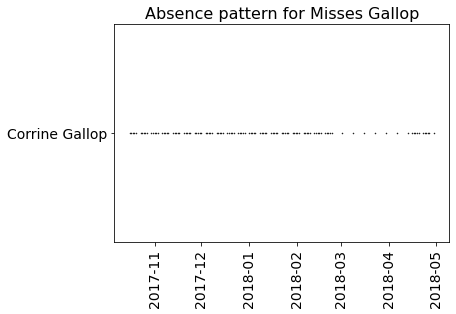

In [15]:
new = []
datum_b = date(2017,6,1)
datum_e = date(2018,5,1)

person_name= "Corrine Gallop"
person = absent_dict[person_name]

for i in person:
    z1 = str(i).split(' ')
    z = str(z1[0]).split('-')
    y = date(int(z[0]), int(z[1]), int(z[2]))
#     print(y)
    if y > datum_b and y < datum_e:
        new.append(i)
        
pers_dict_ = dict()
pers_dict_[person_name] = new

xr, yr = zip(*((x, k) for k in pers_dict_ for x in pers_dict_[k]))
plt.title("Absence pattern for Misses Gallop", fontsize=16)
plt.plot(xr, yr, 'ko', markersize=0.5)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.savefig("plots/gallopB.png", bbox_inches='tight')
plt.show()

## End OWN ABsENcES

#### Absence pattern Marthe Hale

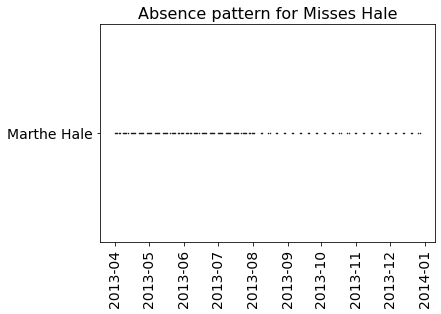

In [16]:
new = []
datum_b = date(2013,3,1)
datum_e = date(2015,1,1)

person_name= "Marthe Hale"
person = absent_dict[person_name]

for i in person:
    z1 = str(i).split(' ')
    z = str(z1[0]).split('-')
    y = date(int(z[0]), int(z[1]), int(z[2]))
#     print(y)
    if y > datum_b and y < datum_e:
        new.append(i)
        
pers_dict_x = dict()
pers_dict_x[person_name] = new

xr, yr = zip(*((x, k) for k in pers_dict_x for x in pers_dict_x[k]))
plt.title("Absence pattern for Misses Hale", fontsize=16)
plt.plot(xr, yr, 'ko', markersize=0.5)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.savefig("plots/haleB.png", bbox_inches='tight')
plt.show()

## End OWN ABsENcES

In [17]:
### Similar abscences ###

# Note: Tora, Lorrine, Hassan and Annie Lapham Chung Zertuche, Kiera, work parttime.
# Note: Also Kiera, but she starts later
# Note: More do not work fully

# Just to omit own
real_pairs = []
vals = []

for pair in co_absence.values:
    if pair[0][0] != pair[0][1]:
        real_pairs.append(pair[0])
        vals.append(pair[1])

# Absences weekends excluded
co_abs_p = pd.DataFrame({'Pair': real_pairs, 'Co-absence': vals})
co_abs_p = co_abs_p.sort_values("Co-absence", ascending=False)


co_absence2 = co_absence.reset_index()
del co_absence2['index']

co_absence2.head()

,Pair,Co-absence
0,"(Lorrine Paek, Lorrine Paek)",771
1,"(Hassan Toner, Hassan Toner)",747
2,"(Tora Echevarria, Tora Echevarria)",728
3,"(Annie Lapham, Annie Lapham)",551
4,"(Chung Zertuche, Chung Zertuche)",420


Now, weekends are excluded in the table presented below:

In [18]:
co_abs_p.head(50)

,Pair,Co-absence
0,"(Lorrine Paek, Hassan Toner)",282
1,"(Lorrine Paek, Tora Echevarria)",278
2,"(Tora Echevarria, Hassan Toner)",267
3,"(Lorrine Paek, Annie Lapham)",220
4,"(Tora Echevarria, Annie Lapham)",200
5,"(Hassan Toner, Annie Lapham)",190
6,"(Lorrine Paek, Chung Zertuche)",169
7,"(Lorrine Paek, Aurea Durrance)",156
8,"(Chung Zertuche, Adriene Wilde)",155
9,"(Hassan Toner, Jarvis Pratts)",155


In [19]:
parttimers = ["Lorrine Paek", "Hassan Toner", "Annie Lapham", "Chung Zertuche", "Aurea Durrance", "Kiera Loar", "Randall Feather",
          "Tora Echevarria", "Jarvis Pratts", "Anisha Mathes", "Adriene Wilde"]
print(parttimers)

['Lorrine Paek', 'Hassan Toner', 'Annie Lapham', 'Chung Zertuche', 'Aurea Durrance', 'Kiera Loar', 'Randall Feather', 'Tora Echevarria', 'Jarvis Pratts', 'Anisha Mathes', 'Adriene Wilde']


#### Identify possible couples by co-absences

Remove parttime workers

In [20]:
possible = []

for i in co_abs_p.values:
    if i[0][0] not in parttimers:
        if i[0][1] not in parttimers:
            possible.append([i[0], i[1]])

In [21]:
x = possible[:5]
x

[[('Vonk Billips', 'Julieta Knapp'), 122],
 [('Augusta Beltrami', 'Grover Gibbons'), 88],
 [('Remedios Fincham', 'Tasia Dube'), 68],
 [('Tasia Dube', 'Leatrice Heer'), 63],
 [('Stephine Gatlin', 'Remedios Fincham'), 63]]

In [22]:
pairs_ = []
amount_ = []

for i in x:
    pairs_.append(i[0])
    amount_.append(i[1])
    
couples = pd.DataFrame()

couples["Pair"] = pairs_
couples["Absence"] = amount_

couples

,Pair,Absence
0,"(Vonk Billips, Julieta Knapp)",122
1,"(Augusta Beltrami, Grover Gibbons)",88
2,"(Remedios Fincham, Tasia Dube)",68
3,"(Tasia Dube, Leatrice Heer)",63
4,"(Stephine Gatlin, Remedios Fincham)",63
